***1. Изучаю датасет и немного работаю с ним***

In [1]:
import os
import urllib.request
import zipfile

def download_and_extract_camvid(dest_folder='data/CamVid'):
    os.makedirs(dest_folder, exist_ok=True)
    url = 'https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz'
    tgz_path = os.path.join(dest_folder, 'camvid.tgz')
    if not os.path.exists(tgz_path):
        print('Скачивание')
        urllib.request.urlretrieve(url, tgz_path)
    else:
        print('Уже скачан')

    import tarfile
    with tarfile.open(tgz_path) as tar:
        tar.extractall(path=dest_folder)
    print('Готово!')

download_and_extract_camvid()

Уже скачан
Готово!


In [2]:
CAMVID_CLASSES = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol',
    'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']

CAMVID_COLORS = [
    [128, 128, 128],  # Sky
    [128, 0, 0],      # Building
    [192, 192, 128],  # Pole
    [128, 64, 128],   # Road
    [0, 0, 192],      # Pavement
    [128, 128, 0],    # Tree
    [192, 128, 128],  # SignSymbol
    [64, 64, 128],    # Fence
    [64, 0, 128],     # Car
    [64, 64, 0],      # Pedestrian
    [0, 128, 192],    # Bicyclist
    [0, 0, 0] ]       # Unlabelled

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])

        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        image = T.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [4]:
import matplotlib.pyplot as plt

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_batch(images, masks, n=4):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].cpu().numpy()
        mask_rgb = decode_segmap(mask)
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(2, n, n+i+1)
        plt.imshow(mask_rgb)
        plt.axis('off')
        plt.title('Mask')
    plt.tight_layout()
    plt.show()

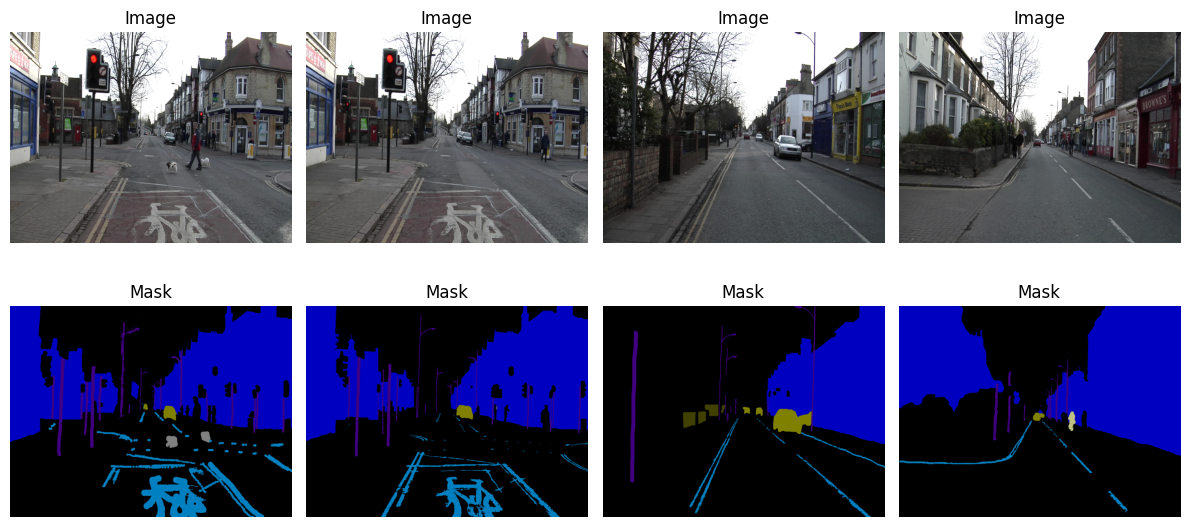

In [5]:
from torch.utils.data import DataLoader

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'
dataset = CamVidDataset(train_images, train_masks)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, masks = next(iter(dataloader))
show_batch(images, masks, n=4)

------------------------------------------------------------------------------

***Начинаю реализовывать сегментацию***

***2. U-Net модель***

In [6]:
! pip install segmentation_models_pytorch

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 176/176 [00:52<00:00,  3.37it/s]


Epoch 1/30, Loss: 0.8003


100%|██████████| 176/176 [00:37<00:00,  4.75it/s]


Epoch 2/30, Loss: 0.3325


100%|██████████| 176/176 [00:36<00:00,  4.85it/s]


Epoch 3/30, Loss: 0.2336


100%|██████████| 176/176 [00:44<00:00,  3.99it/s]


Epoch 4/30, Loss: 0.1958


100%|██████████| 176/176 [00:36<00:00,  4.82it/s]


Epoch 5/30, Loss: 0.1656


100%|██████████| 176/176 [00:36<00:00,  4.78it/s]


Epoch 6/30, Loss: 0.1438


100%|██████████| 176/176 [00:36<00:00,  4.81it/s]


Epoch 7/30, Loss: 0.1214


100%|██████████| 176/176 [00:36<00:00,  4.86it/s]


Epoch 8/30, Loss: 0.1117


100%|██████████| 176/176 [00:36<00:00,  4.77it/s]


Epoch 9/30, Loss: 0.1023


100%|██████████| 176/176 [00:36<00:00,  4.83it/s]


Epoch 10/30, Loss: 0.0934


100%|██████████| 176/176 [00:36<00:00,  4.88it/s]


Epoch 11/30, Loss: 0.0851


100%|██████████| 176/176 [00:36<00:00,  4.77it/s]


Epoch 12/30, Loss: 0.0811


100%|██████████| 176/176 [00:36<00:00,  4.84it/s]


Epoch 13/30, Loss: 0.0744


100%|██████████| 176/176 [00:36<00:00,  4.84it/s]


Epoch 14/30, Loss: 0.0725


100%|██████████| 176/176 [00:36<00:00,  4.80it/s]


Epoch 15/30, Loss: 0.0854


100%|██████████| 176/176 [00:36<00:00,  4.88it/s]


Epoch 16/30, Loss: 0.0959


100%|██████████| 176/176 [00:36<00:00,  4.79it/s]


Epoch 17/30, Loss: 0.0806


100%|██████████| 176/176 [00:36<00:00,  4.81it/s]


Epoch 18/30, Loss: 0.0623


100%|██████████| 176/176 [00:36<00:00,  4.77it/s]


Epoch 19/30, Loss: 0.0550


100%|██████████| 176/176 [00:36<00:00,  4.86it/s]


Epoch 20/30, Loss: 0.0530


100%|██████████| 176/176 [00:36<00:00,  4.87it/s]


Epoch 21/30, Loss: 0.0484


100%|██████████| 176/176 [00:36<00:00,  4.84it/s]


Epoch 22/30, Loss: 0.0447


100%|██████████| 176/176 [00:36<00:00,  4.83it/s]


Epoch 23/30, Loss: 0.0433


100%|██████████| 176/176 [00:36<00:00,  4.85it/s]


Epoch 24/30, Loss: 0.0414


100%|██████████| 176/176 [00:37<00:00,  4.69it/s]


Epoch 25/30, Loss: 0.0458


100%|██████████| 176/176 [00:36<00:00,  4.76it/s]


Epoch 26/30, Loss: 0.1157


100%|██████████| 176/176 [00:36<00:00,  4.76it/s]


Epoch 27/30, Loss: 0.0633


100%|██████████| 176/176 [00:36<00:00,  4.79it/s]


Epoch 28/30, Loss: 0.0616


100%|██████████| 176/176 [00:36<00:00,  4.78it/s]


Epoch 29/30, Loss: 0.0431


100%|██████████| 176/176 [00:36<00:00,  4.87it/s]


Epoch 30/30, Loss: 0.0385


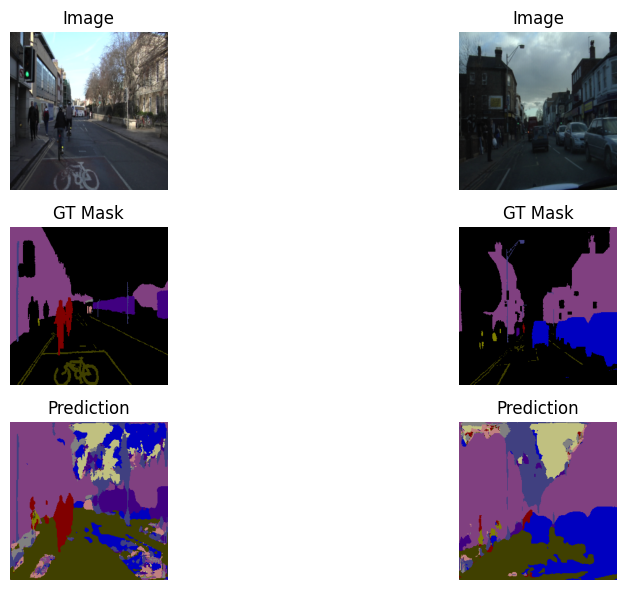

In [7]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

CAMVID_CLASSES = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol',
    'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']

CAMVID_COLORS = [
    [128, 128, 128],
    [128, 0, 0],
    [192, 192, 128],
    [128, 64, 128],
    [0, 0, 192],
    [128, 128, 0],
    [192, 128, 128],
    [64, 64, 128],
    [64, 0, 128],
    [64, 64, 0],
    [0, 128, 192],
    [0, 0, 0] ]

def remap_mask(mask, ignore_index=255):
    mask = np.array(mask)
    mask_new = np.full_like(mask, ignore_index)
    for v in range(1, 12):
        mask_new[mask == v] = v - 1
    mask_new[mask == 255] = ignore_index
    return mask_new

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = remap_mask(mask, ignore_index=255)
        mask = torch.from_numpy(mask).long()
        return image, mask

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()])
target_transform = T.Compose([
    T.Resize((256, 256), interpolation=Image.NEAREST)])

dataset = CamVidDataset(train_images, train_masks, transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(CAMVID_CLASSES),
    activation=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = unet_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
num_epochs = 30

for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_unet_preds(model, dataloader, n=2):
    model.eval()
    images, masks = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy()
        pred = preds[i]
        plt.subplot(3, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(3, n, n+i+1)
        plt.imshow(decode_segmap(mask))
        plt.axis('off')
        plt.title('GT Mask')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(decode_segmap(pred))
        plt.axis('off')
        plt.title('Prediction')
    plt.tight_layout()
    plt.show()

show_unet_preds(unet_model, dataloader, n=2)

In [8]:
def compute_pixel_accuracy(preds, masks, ignore_index=255):
    valid = (masks != ignore_index)
    correct = (preds == masks) & valid
    acc = correct.sum() / valid.sum()
    return acc

def compute_iou(preds, masks, num_classes, ignore_index=255):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        valid = (masks != ignore_index)
        intersection = (pred_inds & target_inds & valid).sum()
        union = ((pred_inds | target_inds) & valid).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious

def evaluate_model(model, dataloader, num_classes, device, ignore_index=255):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            all_preds.append(preds)
            all_masks.append(masks)
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    pixel_acc = compute_pixel_accuracy(all_preds, all_masks, ignore_index)
    ious = compute_iou(all_preds, all_masks, num_classes, ignore_index)
    mean_iou = np.nanmean(ious)
    return pixel_acc, ious, mean_iou

pixel_acc, ious, mean_iou = evaluate_model(unet_model, dataloader, len(CAMVID_CLASSES), device)

df = pd.DataFrame({
    "Class": CAMVID_CLASSES,
    "IoU": ious
})

df["IoU"] = df["IoU"].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df.loc[len(df)] = ["Mean IoU", f"{mean_iou:.4f}"]
df.loc[len(df)] = ["Pixel Accuracy", f"{pixel_acc:.4f}"]

print(df.to_string(index=False))

Evaluating: 100%|██████████| 176/176 [00:28<00:00,  6.19it/s]


         Class    IoU
           Sky 0.8553
      Building 0.9383
          Pole 0.8644
          Road 0.9868
      Pavement 0.9822
          Tree 0.2263
    SignSymbol 0.7559
         Fence 0.7717
           Car 0.9621
    Pedestrian 0.9934
     Bicyclist 0.0006
    Unlabelled    N/A
      Mean IoU 0.7579
Pixel Accuracy 0.9875


-----------------------------

***3. Transformer модель***

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([12]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([12, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 351/351 [01:05<00:00,  5.34it/s]


Epoch 1/30, Loss: 0.5810


100%|██████████| 351/351 [01:05<00:00,  5.36it/s]


Epoch 2/30, Loss: 0.2292


100%|██████████| 351/351 [01:06<00:00,  5.29it/s]


Epoch 3/30, Loss: 0.1694


100%|██████████| 351/351 [01:05<00:00,  5.33it/s]


Epoch 4/30, Loss: 0.1469


100%|██████████| 351/351 [01:05<00:00,  5.34it/s]


Epoch 5/30, Loss: 0.1204


100%|██████████| 351/351 [01:06<00:00,  5.30it/s]


Epoch 6/30, Loss: 0.1084


100%|██████████| 351/351 [01:05<00:00,  5.33it/s]


Epoch 7/30, Loss: 0.0951


100%|██████████| 351/351 [01:05<00:00,  5.36it/s]


Epoch 8/30, Loss: 0.0931


100%|██████████| 351/351 [01:06<00:00,  5.28it/s]


Epoch 9/30, Loss: 0.0960


100%|██████████| 351/351 [01:05<00:00,  5.34it/s]


Epoch 10/30, Loss: 0.0871


100%|██████████| 351/351 [01:05<00:00,  5.36it/s]


Epoch 11/30, Loss: 0.0752


100%|██████████| 351/351 [01:06<00:00,  5.31it/s]


Epoch 12/30, Loss: 0.0732


100%|██████████| 351/351 [01:05<00:00,  5.33it/s]


Epoch 13/30, Loss: 0.0773


100%|██████████| 351/351 [01:05<00:00,  5.35it/s]


Epoch 14/30, Loss: 0.0672


100%|██████████| 351/351 [01:05<00:00,  5.34it/s]


Epoch 15/30, Loss: 0.0729


100%|██████████| 351/351 [01:06<00:00,  5.29it/s]


Epoch 16/30, Loss: 0.0633


100%|██████████| 351/351 [01:05<00:00,  5.34it/s]


Epoch 17/30, Loss: 0.0688


100%|██████████| 351/351 [01:05<00:00,  5.36it/s]


Epoch 18/30, Loss: 0.0596


100%|██████████| 351/351 [01:05<00:00,  5.37it/s]


Epoch 19/30, Loss: 0.0551


100%|██████████| 351/351 [01:06<00:00,  5.29it/s]


Epoch 20/30, Loss: 0.0557


100%|██████████| 351/351 [01:05<00:00,  5.38it/s]


Epoch 21/30, Loss: 0.0509


100%|██████████| 351/351 [01:05<00:00,  5.33it/s]


Epoch 22/30, Loss: 0.0498


100%|██████████| 351/351 [01:06<00:00,  5.24it/s]


Epoch 23/30, Loss: 0.0481


100%|██████████| 351/351 [01:06<00:00,  5.31it/s]


Epoch 24/30, Loss: 0.0523


100%|██████████| 351/351 [01:06<00:00,  5.28it/s]


Epoch 25/30, Loss: 0.0904


100%|██████████| 351/351 [01:06<00:00,  5.30it/s]


Epoch 26/30, Loss: 0.0522


100%|██████████| 351/351 [01:06<00:00,  5.31it/s]


Epoch 27/30, Loss: 0.0493


100%|██████████| 351/351 [01:05<00:00,  5.35it/s]


Epoch 28/30, Loss: 0.0460


100%|██████████| 351/351 [01:05<00:00,  5.35it/s]


Epoch 29/30, Loss: 0.0437


100%|██████████| 351/351 [01:06<00:00,  5.29it/s]


Epoch 30/30, Loss: 0.0430


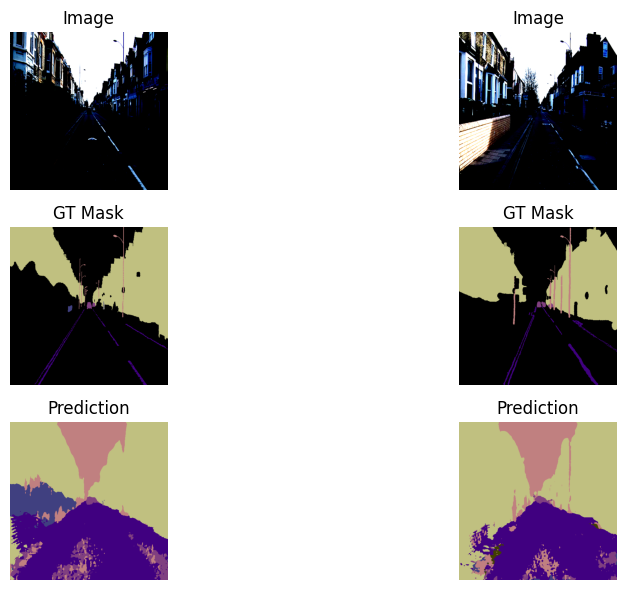

Evaluating: 100%|██████████| 351/351 [00:51<00:00,  6.88it/s]


         Class    IoU
           Sky 0.9471
      Building 0.9688
          Pole 0.9835
          Road 0.9829
      Pavement 0.7079
          Tree 0.7735
    SignSymbol 0.6892
         Fence 0.9579
           Car 0.9918
    Pedestrian 0.7356
     Bicyclist    N/A
    Unlabelled    N/A
      Mean IoU 0.8738
Pixel Accuracy 0.9854


In [9]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

def remap_mask(mask, ignore_index=255):
    mask = np.array(mask)
    mask_new = np.full_like(mask, ignore_index)
    for v in range(1, 12):
        mask_new[mask == v] = v - 1
    mask_new[mask == 255] = ignore_index
    return mask_new

class CamVidDatasetHF(Dataset):
    def __init__(self, images_dir, masks_dir, processor, ignore_index=255):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.processor = processor
        self.ignore_index = ignore_index
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        mask = remap_mask(mask, ignore_index=self.ignore_index)
        processed = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")
        pixel_values = processed['pixel_values'].squeeze(0)
        labels = processed['labels'].squeeze(0)
        return pixel_values, labels

train_images = 'data/CamVid/camvid/images'
train_masks = 'data/CamVid/camvid/labels'

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=len(CAMVID_CLASSES),
    ignore_mismatched_sizes=True)

dataset_hf = CamVidDatasetHF(train_images, train_masks, processor)
dataloader_hf = DataLoader(dataset_hf, batch_size=2, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segformer_model = segformer_model.to(device)
optimizer = optim.AdamW(segformer_model.parameters(), lr=1e-4)
num_epochs = 30

for epoch in range(num_epochs):
    segformer_model.train()
    running_loss = 0.0
    for pixel_values, labels in tqdm(dataloader_hf):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = segformer_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * pixel_values.size(0)
    epoch_loss = running_loss / len(dataset_hf)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def decode_segmap(mask, colormap=CAMVID_COLORS):
    mask = np.array(mask)
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colormap):
        rgb[mask == i] = color
    return rgb

def show_segformer_preds(model, dataloader, n=2):
    model.eval()
    pixel_values, labels = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values.to(device))
        logits = outputs.logits
        logits = torch.nn.functional.interpolate(
            logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
        )
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = pixel_values[i].permute(1, 2, 0).cpu().numpy()
        mask = labels[i].cpu().numpy()
        pred = preds[i]
        plt.subplot(3, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(3, n, n+i+1)
        plt.imshow(decode_segmap(mask))
        plt.axis('off')
        plt.title('GT Mask')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(decode_segmap(pred))
        plt.axis('off')
        plt.title('Prediction')
    plt.tight_layout()
    plt.show()

show_segformer_preds(segformer_model, dataloader_hf, n=2)

def compute_pixel_accuracy(preds, masks, ignore_index=255):
    valid = (masks != ignore_index)
    correct = (preds == masks) & valid
    acc = correct.sum() / valid.sum()
    return acc

def compute_iou(preds, masks, num_classes, ignore_index=255):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        valid = (masks != ignore_index)
        intersection = (pred_inds & target_inds & valid).sum()
        union = ((pred_inds | target_inds) & valid).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious

def evaluate_model(model, dataloader, num_classes, device, ignore_index=255):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for pixel_values, labels in tqdm(dataloader, desc="Evaluating"):
            pixel_values = pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = torch.nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode='bilinear', align_corners=False
            )
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.append(preds)
            all_masks.append(labels)
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    pixel_acc = compute_pixel_accuracy(all_preds, all_masks, ignore_index)
    ious = compute_iou(all_preds, all_masks, num_classes, ignore_index)
    mean_iou = np.nanmean(ious)
    return pixel_acc, ious, mean_iou

pixel_acc, ious, mean_iou = evaluate_model(segformer_model, dataloader_hf, len(CAMVID_CLASSES), device)

df = pd.DataFrame({
    "Class": CAMVID_CLASSES,
    "IoU": ious})

df["IoU"] = df["IoU"].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df.loc[len(df)] = ["Mean IoU", f"{mean_iou:.4f}"]
df.loc[len(df)] = ["Pixel Accuracy", f"{pixel_acc:.4f}"]

print(df.to_string(index=False))

------------------------------------------------

***Смотрю кол-во параметров и время на обучение моделей***

In [ ]:
import time

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(CAMVID_CLASSES),
    activation=None)

unet_model = unet_model.to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
num_epochs = 5

for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / 1024**3

print(f"\nU-Net:")
print(f"Время обучения: {(end_time - start_time):.2f} секунд")
print(f"Пиковое потребление GPU-памяти: {peak_memory:.2f} ГБ")
print(f"Параметров в модели: {count_params(unet_model):,}")

100%|██████████| 176/176 [00:36<00:00,  4.88it/s]


Epoch 1/5, Loss: 1.2644


100%|██████████| 176/176 [00:35<00:00,  4.99it/s]


Epoch 2/5, Loss: 0.4405


100%|██████████| 176/176 [00:36<00:00,  4.80it/s]


Epoch 3/5, Loss: 0.2683


100%|██████████| 176/176 [00:35<00:00,  4.99it/s]


Epoch 4/5, Loss: 0.2023


100%|██████████| 176/176 [00:35<00:00,  4.90it/s]

Epoch 5/5, Loss: 0.1720

U-Net:
Время обучения: 179.83 секунд
Пиковое потребление GPU-памяти: 1.04 ГБ
Параметров в модели: 24,437,964


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=len(CAMVID_CLASSES), ignore_mismatched_sizes=True)

segformer_model = segformer_model.to(device)
optimizer = optim.AdamW(segformer_model.parameters(), lr=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    segformer_model.train()
    running_loss = 0.0
    for pixel_values, labels in tqdm(dataloader_hf):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = segformer_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * pixel_values.size(0)
    epoch_loss = running_loss / len(dataset_hf)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / 1024**3

print(f"\nSegFormer:")
print(f"Время обучения: {(end_time - start_time):.2f} секунд")
print(f"Пиковое потребление GPU-памяти: {peak_memory:.2f} ГБ")
print(f"Параметров в модели: {count_params(segformer_model):,}")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([12]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([12, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 351/351 [01:05<00:00,  5.40it/s]


Epoch 1/5, Loss: 0.5262


100%|██████████| 351/351 [01:05<00:00,  5.37it/s]


Epoch 2/5, Loss: 0.2256


100%|██████████| 351/351 [01:05<00:00,  5.38it/s]


Epoch 3/5, Loss: 0.1634


100%|██████████| 351/351 [01:20<00:00,  4.34it/s]


Epoch 4/5, Loss: 0.1356


100%|██████████| 351/351 [01:12<00:00,  4.83it/s]

Epoch 5/5, Loss: 0.1173

SegFormer:
Время обучения: 350.46 секунд
Пиковое потребление GPU-памяти: 1.43 ГБ
Параметров в модели: 3,717,228


-------------------------------------------------------